In [1]:
!pip install openpyxl textdistance

You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.9.1/envs/hc/bin/python -m pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../..")

import pandas as pd
import numpy as np
import seaborn as sns

import textdistance
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz

from hc_nlp.constants import ORG_LEGAL_SUFFIXES
from heritageconnector.nlp.nel import NELFeatureGenerator

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

pd.options.display.max_rows = None

In [3]:
# df = pd.read_excel("../../../GITIGNORE_DATA/NEL/KD copy of review_data.xlsx 240221.xlsx")
df = pd.read_excel("../../../GITIGNORE_DATA/NEL/review_data_1103.xlsx", index_col=0)
df.loc[~df['link_correct'].isnull(), 'link_correct'] = df.loc[~df['link_correct'].isnull(), 'link_correct'].apply(int)
# df = df.drop(columns=["item_uri.1", "candidate_uri.1"])
df['ent_label'] = df['ent_label'].map({"PERSON": "PERSON", "OBJECT": "OBJECT", "ORG": "ORGANISATION"})
df['link_correct'] = df['link_correct'].map({0: False, 1: True})
df['_type_match'] = (df['ent_label'] == df['candidate_type'])
df[["ent_text", "candidate_title"]] = df[["ent_text", "candidate_title"]].astype(str)
df['_ent_candidate_distance'] = df.apply(lambda x: distance(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_similarity'] = df.apply(lambda x: ratio(x["ent_text"], x["candidate_title"]), axis=1)
df['_ent_candidate_sorted_similarity'] = df.apply(lambda x: fuzz.token_sort_ratio(x["ent_text"], x["candidate_title"])/100, axis=1)

df_annotated_not_in_search = df[df['candidate_rank'] == -1]
df_annotated = df[(~df['link_correct'].isnull()) & (df['candidate_rank'] != -1)]

df_unannotated = df[df['link_correct'].isnull()]

len(df), len(df_annotated), len(df_annotated_not_in_search), len(df_unannotated)

(5619, 1407, 8, 4204)

In [4]:
df_annotated.head()

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity
0.0,https://collection.sciencemuseumgroup.org.uk/o...,0,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"British Railways came into existence, as the b...",Notice. British Railways (Southern Region). Ma...,True,0,1.000000,1.00
1.0,https://collection.sciencemuseumgroup.org.uk/o...,1,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Poster, British Railways poster (Waterlow & So...",Notice. British Railways (Southern Region). Ma...,False,0,1.000000,1.00
2.0,https://collection.sciencemuseumgroup.org.uk/o...,2,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Christmas card from James Ness, The Railway Ex...",Notice. British Railways (Southern Region). Ma...,False,0,1.000000,1.00
3.0,https://collection.sciencemuseumgroup.org.uk/o...,3,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,British Railways,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Cap badge, BR (ScR), ""Lion on wheel"" device, w...",Notice. British Railways (Southern Region). Ma...,False,0,1.000000,1.00
4.0,https://collection.sciencemuseumgroup.org.uk/o...,4,Notice. [[British Railways]] (Southern Region)...,ORGANISATION,British Railways,British Railways (Southern Region).,"Worksplate, British Railways, ""British Railway...",OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,False,NaN,"Worksplate, British Railways, ""British Railway...",Notice. British Railways (Southern Region). Ma...,False,44,0.421053,0.44


## 1. Analysing annotations

In [5]:
print(f"Total number of true annotations: {sum(df_annotated.link_correct)}")
# print(f"Number of entity mentions with at least one true annotation: {(df_annotated.groupby(['item_uri', 'ent_text']).sum() > 0)['link_correct'].sum()}")

Total number of true annotations: 82


#### entity type

is entity type a good predictor of a match? -> **yes**

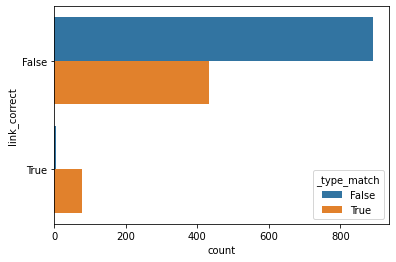

In [6]:
sns.countplot(y="link_correct", hue="_type_match", data=df_annotated);

### 1.1. Planning a Baseline predictor
1. Use **text similarity only** as a predictor of whether an entity mention maps to a SMG record.

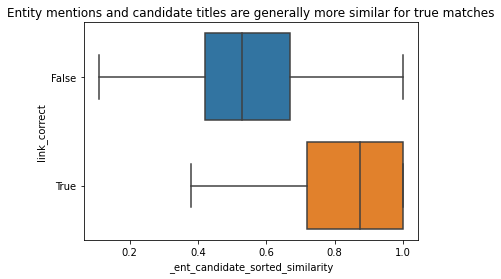

In [7]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", orient='h', showfliers=False)
g.set_title("Entity mentions and candidate titles are generally more similar for true matches");


2. Use **text similarity and matched type** as a predictor of whether an entity mention maps to an SMG record.

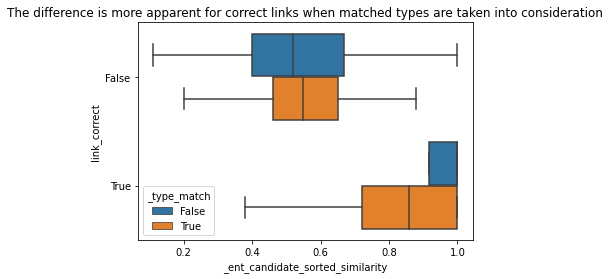

In [8]:
g = sns.boxplot(data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)
g.set_title("The difference is more apparent for correct links when matched types are taken into consideration");

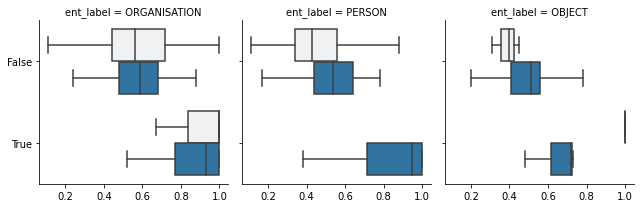

In [9]:
g = sns.FacetGrid(df_annotated, col="ent_label")
g.map_dataframe(sns.boxplot, data=df_annotated, x="_ent_candidate_sorted_similarity", y="link_correct", hue="_type_match", orient='h', showfliers=False)

## 2. Building a Baseline Predictor
- assume an entity mention and record are linked if `fuzz.token_sort_ratio(ent_mention, record_title)` is greater than a threshold, and the predicted entity mention type is the same as the record type
- set this threshold initially to 0.8 based on the above plot and then tune it for accuracy

In [10]:
threshold = 0.8
sim_metric_col = "_ent_candidate_sorted_similarity"

df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])

In [11]:
def calc_metrics(data, gt_col, pred_col):
    tp = len(data[data[gt_col] & data[pred_col]])
    fp = len(data[~data[gt_col] & data[pred_col]])
    tn = len(data[~data[gt_col] & ~data[pred_col]])
    fn = len(data[data[gt_col] & ~data[pred_col]])
    
    acc = (tp + tn) / (tp + fp + tn + fn)
    pr = tp / (tp + fp)
    re = tp / (tp + fn)
    f1 = (2 * pr * re) / (pr + re)
    
    return {"f1": f1, "precision": pr, "recall": re, "accuracy": acc}
    

print("OVERALL")
print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

for t in ["PERSON", "OBJECT", "ORGANISATION"]:
    print(t)
    print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

OVERALL
{'f1': 0.6293706293706294, 'precision': 0.7377049180327869, 'recall': 0.5487804878048781, 'accuracy': 0.9623312011371713}
PERSON
{'f1': 0.8148148148148148, 'precision': 1.0, 'recall': 0.6875, 'accuracy': 0.9874371859296482}
OBJECT
{'f1': 0.19354838709677416, 'precision': 0.3, 'recall': 0.14285714285714285, 'accuracy': 0.8226950354609929}
ORGANISATION
{'f1': 0.7294117647058822, 'precision': 0.775, 'recall': 0.6888888888888889, 'accuracy': 0.9735023041474654}


In [12]:
for threshold in (0.6, 0.7, 0.75, 0.8, 0.85):
    df_annotated['baseline_prediction'] = (df_annotated[sim_metric_col] >= threshold) & (df_annotated["_type_match"])
    
    print(f"--- {threshold} ---")
    print(calc_metrics(df_annotated, 'link_correct', 'baseline_prediction'))

    for t in ["PERSON", "OBJECT", "ORGANISATION"]:
        print(t)
        print(calc_metrics(df_annotated.loc[df_annotated["ent_label"] == t, :], 'link_correct', 'baseline_prediction'))

--- 0.6 ---
{'f1': 0.43870967741935485, 'precision': 0.2982456140350877, 'recall': 0.8292682926829268, 'accuracy': 0.8763326226012793}
PERSON
{'f1': 0.42424242424242425, 'precision': 0.28, 'recall': 0.875, 'accuracy': 0.9045226130653267}
OBJECT
{'f1': 0.5333333333333333, 'precision': 0.41025641025641024, 'recall': 0.7619047619047619, 'accuracy': 0.8014184397163121}
ORGANISATION
{'f1': 0.4130434782608696, 'precision': 0.2733812949640288, 'recall': 0.8444444444444444, 'accuracy': 0.8755760368663594}
--- 0.7 ---
{'f1': 0.6086956521739131, 'precision': 0.504, 'recall': 0.7682926829268293, 'accuracy': 0.9424307036247335}
PERSON
{'f1': 0.5853658536585366, 'precision': 0.48, 'recall': 0.75, 'accuracy': 0.957286432160804}
OBJECT
{'f1': 0.5957446808510638, 'precision': 0.5384615384615384, 'recall': 0.6666666666666666, 'accuracy': 0.8652482269503546}
ORGANISATION
{'f1': 0.6218487394957983, 'precision': 0.5, 'recall': 0.8222222222222222, 'accuracy': 0.9481566820276498}
--- 0.75 ---
{'f1': 0.56626

## 3. Building a machine learning predictor
Using only the mention, title, and types of each.

In [35]:
f = NELFeatureGenerator()
f = f.fit(df_annotated, ent_mention_col='ent_text', ent_type_col='ent_label', ent_context_col='item_description', 
        candidate_title_col='candidate_title', candidate_type_col='candidate_type', candidate_context_col='candidate_description')

X = f.transform(df_annotated)

X.shape
y = list(1*(df_annotated['link_correct'].values))

2021-03-18 13:23:43,732 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (1/2)
2021-03-18 13:23:43,732 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (1/2)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2021-03-18 13:23:47,139 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (2/2)
2021-03-18 13:23:47,139 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (2/2)


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

In [36]:
X.shape, len(y)

((1407, 16), 1407)

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

def test_classifiers(X, y):
    all_scores = {}
    
    # SVM
    svm = SVC(random_state=0, kernel='linear', probability=True)
    scores = cross_validate(svm, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['SVM'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # logistic regression
    log_r = LogisticRegressionCV(cv=5, random_state=0, max_iter=500).fit(X, list(y))

    scores = cross_validate(log_r, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['logr'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    # MLP    
    mlp = MLPClassifier(random_state=0, max_iter=1000)

    scores = cross_validate(mlp, X, y, cv=10, scoring=['precision_macro', 'recall_macro'])

    all_scores['MLP'] = (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()), (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std())
    
    return (svm, log_r, mlp), all_scores

(svm, log_r, mlp), scores = test_classifiers(X, y)
scores

{'SVM': ((0.8857560247204266, 0.0951702740977622),
  (0.7658715918584338, 0.09557413141585487)),
 'logr': ((0.9010077639628351, 0.09941743355565327),
  (0.7891096111490847, 0.07151490089875455)),
 'MLP': ((0.8663592213754227, 0.11464085326683651),
  (0.8325581947292473, 0.07230089777501289))}

### 3.1 Test on unannotated data

In [18]:
X_un = f.transform(df_unannotated)

X_un.shape

2021-03-17 16:19:52,185 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (1/2)


Batches:   0%|          | 0/132 [00:00<?, ?it/s]

2021-03-17 16:22:07,053 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (2/2)


Batches:   0%|          | 0/132 [00:00<?, ?it/s]

(4204, 16)

In [19]:
classifier = svm.fit(X, y)

# feature importance if classifier is an SVM with a linear kernel
# print([(idx, coef**2) for idx,coef in enumerate(list(classifier.coef_[0]))])

df_unannotated['log_r_prediction'] = classifier.predict(X_un)
df_unannotated['log_r_prediction_proba'] = classifier.predict_proba(X_un)[:,1]

df_unannotated[df_unannotated['log_r_prediction'] == 1].head(100).sort_values("log_r_prediction_proba", ascending=False)



,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,log_r_prediction,log_r_prediction_proba
2997.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Coffee cup, ceramic, Great Central Railway - G...",OBJECT,Spode,"Coffee cup, ceramic, Great Central Railway - G...",Spode,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Manufacturer of ceramics, porcelain, Parian wa...","Coffee cup, ceramic, Great Central Railway - G...",False,0,1.000000,1.00,1,0.999998
1749.0,https://collection.sciencemuseumgroup.org.uk/o...,1,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,A black and white silver gelatin photograph en...,A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.999989
1748.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,A black and white silver gelatin photograph en...,A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.996033
2998.0,https://collection.sciencemuseumgroup.org.uk/o...,1,"Coffee cup, ceramic, Great Central Railway - G...",OBJECT,Spode,"Coffee cup, ceramic, Great Central Railway - G...",Spode Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Manufacturer of ceramics, porcelain, Parian wa...","Coffee cup, ceramic, Great Central Railway - G...",False,8,0.555556,0.56,1,0.991657
1875.0,https://collection.sciencemuseumgroup.org.uk/p...,1,"Clifton, G.,'Directory of British Scientific I...",PERSON,George Knight,Name used before & after death of George Knigh...,George Knight & Sons,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Clifton, G.,'Directory of British Scientific I...","Clifton, G.,'Directory of British Scientific I...",False,7,0.787879,0.84,1,0.990835
1778.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,OBJECT,Working the Surface of the Earth,From the Impressions Gallery exhibition 'Worki...,Working the Surface of the Earth,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"Poster, entitled 'Working the Surface of the E...",A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.973453
1750.0,https://collection.sciencemuseumgroup.org.uk/o...,2,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,The London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"An unmounted, black and white silver gelatin p...",A black and white silver gelatin photograph en...,True,4,0.913043,0.91,1,0.966092
1885.0,https://collection.sciencemuseumgroup.org.uk/p...,1,"Clifton, G.,'Directory of British Scientific I...",ORGANISATION,G. Knight & Son,Name used before & after death of George Knigh...,George Knight & Sons,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Clifton, G.,'Directory of British Scientific I...","Clifton, G.,'Directory of British Scientific I...",True,6,0.800000,0.80,1,0.951315
2867.0,https://collection.sciencemuseumgroup.org.uk/o...,0,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",ORGANISATION,Siemens,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",Siemens,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,1847 - founded by Werner von Siemens and Johan...,"Siemens valve, type 15A, marked CV986, (RMW/Y5...",True,0,1.000000,1.00,1,0.9488

### 3.2 What about rows that didn't make the top *n* search results?

*Performance is not great*, but there are only 8 samples. This can be fixed by boosting the correct type in the search results.

In [21]:
# add [object,object] row onto end as it doesn't exist in the original data
df_newrows = df_annotated_not_in_search.append(df_annotated.loc[(df_annotated["ent_label"] == "OBJECT") & (df_annotated["candidate_type"] == "OBJECT")].iloc[0])

X_missed = f.transform(df_newrows)


y_missed = list(1*df['link_correct'].values)


2021-03-17 16:24:40,045 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (1/2)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2021-03-17 16:24:40,633 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (2/2)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
df_annotated_not_in_search['pred'] = svm.predict(X_missed)[0:-1]
df_annotated_not_in_search['pred_proba'] = svm.predict_proba(X_missed)[:-1,1]

df_annotated_not_in_search

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,pred,pred_proba
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,Graduated mercury thermometer used by [[James ...,PERSON,James Joule,NaN,James Prescott Joule,PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"1818-1889, physicist, English, British",Graduated mercury thermometer used by James Jo...,True,9,0.709677,0.71,0,0.142610
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"Royal Coat of Arms, [[Great Northern Railway]]...",ORGANISATION,Great Northern Railway,NaN,Great Northern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,Established in the 1846 London and York Railwa...,"Royal Coat of Arms, Great Northern Railway. Fr...",True,0,1.000000,1.00,1,0.873571
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"'England by the Sea' maquette, made by [[Tony ...",PERSON,Tony Ray-Jones,NaN,"Ray-Jones, Tony",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,Freelance photographer working in London and A...,"'England by the Sea' maquette, made by Tony Ra...",True,11,0.620690,1.00,0,0.486240
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"'England by the Sea' maquette, made by Tony Ra...",PERSON,Tony Ray-Jones,NaN,"Ray-Jones, Tony",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,Freelance photographer working in London and A...,"'England by the Sea' maquette, made by Tony Ra...",True,11,0.620690,1.00,0,0.486240
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"Pen and ink, watercolour and carriage oils on ...",ORGANISATION,Barker & Co.,NaN,Barker and Company Limited,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"Barker and Company, Coachbuilders, 1710-1938 ...","Pen and ink, watercolour and carriage oils on ...",True,16,0.526316,0.51,0,0.063424
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,Leaflet. Reproduction timetable leaflet produ...,ORGANISATION,the Southern Railway,NaN,Southern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"The Southern Railway in the United Kingdom, wh...",Leaflet. Reproduction timetable leaflet produ...,True,4,0.888889,0.89,1,0.837942
NaN,https://collection.sciencemuseumgroup.org.uk/p...,-1,Simpson became Physician to [[Queen Victoria]]...,PERSON,Queen Victoria,NaN,Victoria,PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,1837 - succeeded King William IV upon his death.,Simpson became Physician to Queen Victoria in ...,True,6,0.727273,0.73,0,0.411098
NaN,https://collection.sciencemuseumgroup.org.uk/o...,-1,"[[Spencer Wells]] artery forceps, screw-joint,...",PERSON,Spencer Wells,NaN,"Wells, Sir Thomas Spencer",PERSON,https://collection.sciencemuseumgroup.org.uk/p...,True,NaN,"ane Eliot Sewell, ‘Wells, Sir Thomas Spencer, ...","Spencer Wells artery forceps, screw-joint, pla...",True,22,0.368421,0.70,0,0.236431


## 4. Combining into a scikit-learn pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [27]:
pipe = Pipeline([('featgen', NELFeatureGenerator()), ('svc', SVC(random_state=0, kernel='linear', probability=True))])

In [28]:
pipe = pipe.fit(df_annotated, y=list(1*df_annotated['link_correct'].values), featgen__ent_mention_col='ent_text', featgen__ent_type_col='ent_label', featgen__ent_context_col='item_description', 
        featgen__candidate_title_col='candidate_title', featgen__candidate_type_col='candidate_type', featgen__candidate_context_col='candidate_description')

2021-03-17 16:26:50,685 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (1/2)


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

2021-03-17 16:27:28,936 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (2/2)


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [33]:
df_unannotated_small = df_unannotated.head(500)
y_pred_proba = pipe.predict_proba(df_unannotated_small)
df_unannotated_small['y_pred_proba'] = y_pred_proba[:,1]

2021-03-17 16:30:16,283 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (1/2)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-03-17 16:30:33,642 - heritageconnector.nlp.nel - INFO - Calculating sBERT embeddings... (2/2)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [34]:
df_unannotated_small.sort_values("y_pred_proba", ascending=False).head(10)

,item_uri,candidate_rank,item_description_with_ent,ent_label,ent_text,ent_sentence,candidate_title,candidate_type,candidate_uri,link_correct,candidate_alias,candidate_description,item_description,_type_match,_ent_candidate_distance,_ent_candidate_similarity,_ent_candidate_sorted_similarity,log_r_prediction,log_r_prediction_proba,y_pred_proba
1749.0,https://collection.sciencemuseumgroup.org.uk/o...,1,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,A black and white silver gelatin photograph en...,A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.999989,0.999989
1748.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,A black and white silver gelatin photograph en...,A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.996033,0.996033
1875.0,https://collection.sciencemuseumgroup.org.uk/p...,1,"Clifton, G.,'Directory of British Scientific I...",PERSON,George Knight,Name used before & after death of George Knigh...,George Knight & Sons,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Clifton, G.,'Directory of British Scientific I...","Clifton, G.,'Directory of British Scientific I...",False,7,0.787879,0.84,1,0.990835,0.990835
1778.0,https://collection.sciencemuseumgroup.org.uk/o...,0,A black and white silver gelatin photograph en...,OBJECT,Working the Surface of the Earth,From the Impressions Gallery exhibition 'Worki...,Working the Surface of the Earth,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"Poster, entitled 'Working the Surface of the E...",A black and white silver gelatin photograph en...,True,0,1.000000,1.00,1,0.973453,0.973453
1750.0,https://collection.sciencemuseumgroup.org.uk/o...,2,A black and white silver gelatin photograph en...,OBJECT,London Metal Exchange,A black and white silver gelatin photograph en...,The London Metal Exchange,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"An unmounted, black and white silver gelatin p...",A black and white silver gelatin photograph en...,True,4,0.913043,0.91,1,0.966092,0.966091
1885.0,https://collection.sciencemuseumgroup.org.uk/p...,1,"Clifton, G.,'Directory of British Scientific I...",ORGANISATION,G. Knight & Son,Name used before & after death of George Knigh...,George Knight & Sons,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"Clifton, G.,'Directory of British Scientific I...","Clifton, G.,'Directory of British Scientific I...",True,6,0.800000,0.80,1,0.951315,0.951315
1585.0,https://collection.sciencemuseumgroup.org.uk/o...,5,"Poster, [[London & North Eastern Railway]], We...",ORGANISATION,London & North Eastern Railway,"Poster, London & North Eastern Railway, Wester...",London & North Eastern Railway,ORGANISATION,https://collection.sciencemuseumgroup.org.uk/p...,NaN,NaN,"; Ferneyhough Frank, 'The History of Railways ...","Poster, London & North Eastern Railway, Wester...",True,0,1.000000,1.00,1,0.938570,0.938570
1780.0,https://collection.sciencemuseumgroup.org.uk/o...,2,A black and white silver gelatin photograph en...,OBJECT,Working the Surface of the Earth,From the Impressions Gallery exhibition 'Worki...,Working the surface of the Earth,OBJECT,https://collection.sciencemuseumgroup.org.uk/o...,NaN,NaN,"Black & White Photograph, entitled 'Working th...",A black and white silver gelatin photograph en...,True,1,0.968750,1.00,1,0.934743,0.934743
1738.0,https://collection.sciencemuseumgroup.org.uk/o...,0,LSWR carriage photographs. Two colour photogra...,ORGANISATION,The Photochrom Company Limited,Colour photography by The Photochrom Company L...,The Photochrom Com